In [1]:
%load_ext watermark
%watermark

2020-07-05T21:12:00+08:00

CPython 3.7.4
IPython 7.4.0

compiler   : Clang 11.0.0 (clang-1100.0.33.8)
system     : Darwin
release    : 18.7.0
machine    : x86_64
processor  : i386
CPU cores  : 4
interpreter: 64bit


In [2]:
import torch
import torch.nn.functional as F
import tensorflow as tf
from tensorflow.keras import layers

%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np

from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

## Data

In [147]:
X, y = make_circles(n_samples=200, noise=0.05, factor=0.5)

In [148]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, v_val = train_test_split(X_train, y_train, test_size=0.2)
print(X_train.shape, X_val.shape, X_test.shape)

x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

(128, 2) (32, 2) (40, 2)


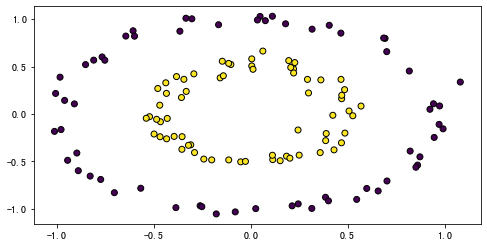

In [149]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 4))
ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train,  edgecolors='k');

## Model

### SVM

In [150]:
clf = SVC(kernel='rbf', probability=True)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


1.0

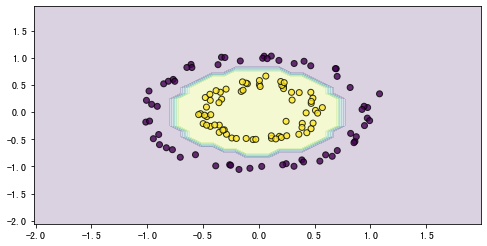

In [151]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 4))

Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

ax.contourf(xx, yy, Z, alpha=0.2)
ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, edgecolors='k', alpha=0.8);

### DNN

In [190]:
def gelu(x):
    return 0.5 * x * (1 + tf.math.tanh(x * 0.7978845608 * (1 + 0.044715 * x * x)))

In [191]:
# None 时为线性激活函数（维度不变），也可以为其他函数，比如：tf.math.sin
model = tf.keras.Sequential([
    layers.Dense(32, activation=gelu),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'],
              run_eagerly=True)

model.fit(X_train, y_train, epochs=50, verbose=0);

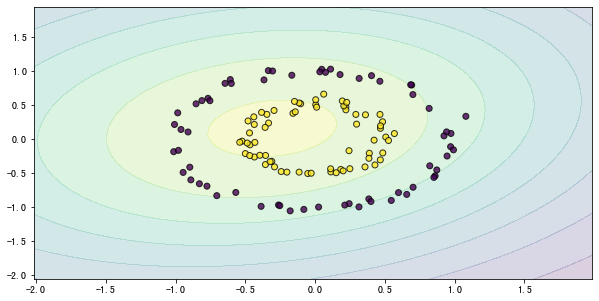

In [192]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))

Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

ax.contourf(xx, yy, Z, alpha=0.2)
ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, edgecolors='k', alpha=0.8);

In [193]:
y_pred = model.predict(X_test) > 0.5

acc = np.sum(y_pred == y_test[:, np.newaxis]) / len(y_test)
acc

### Analysis

In [209]:
def train_dim(dim):
    model = tf.keras.Sequential([
        layers.Dense(dim, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'],
                  run_eagerly=True)

    model.fit(X_train, y_train, epochs=50, verbose=0);
    return model

In [229]:
def train_layer_num(layer_num):
    model = tf.keras.models.Sequential()
    for i in range(layer_num):
        model.add(layers.Dense(8, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'],
                  run_eagerly=True)

    model.fit(X_train, y_train, epochs=50, verbose=0);
    return model

In [205]:
def get_acc(model):
    y_pred = model.predict(X_test) > 0.5
    acc = np.sum(y_pred == y_test[:, np.newaxis]) / len(y_test)
    return acc

Dim 4's Acc: 0.350000
Dim 8's Acc: 0.575000
Dim 32's Acc: 0.875000
Dim 64's Acc: 1.000000


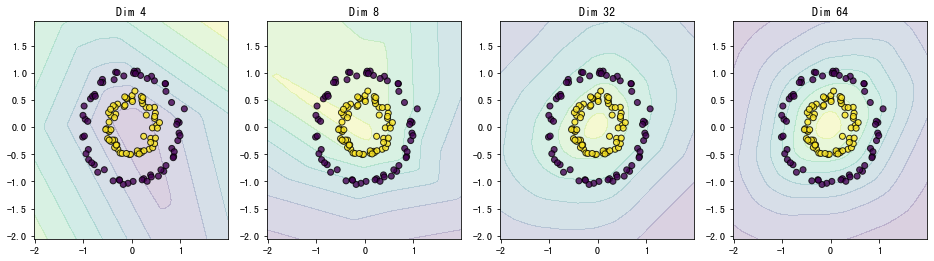

In [208]:
fig = plt.figure(figsize=(16, 4))
for i, dim in enumerate([4, 8, 32, 64]):
    ax = plt.subplot(1, 4, i+1)
    model = train_dim(dim)
    acc = get_acc(model)
    print("Dim %d's Acc: %f" % (dim, acc))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.set_title("Dim {}".format(dim))
    ax.contourf(xx, yy, Z, alpha=0.2)
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, edgecolors='k', alpha=0.8)

LayerNum 1's Acc: 0.700000
LayerNum 2's Acc: 0.725000
LayerNum 3's Acc: 0.850000
LayerNum 4's Acc: 0.700000


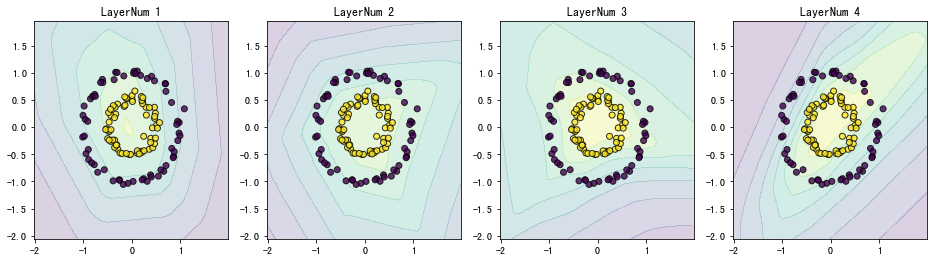

In [233]:
fig = plt.figure(figsize=(16, 4))
for i in range(1, 5):
    ax = plt.subplot(1, 4, i)
    model = train_layer_num(i)
    acc = get_acc(model)
    print("LayerNum %d's Acc: %f" % (i, acc))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.set_title("LayerNum {}".format(i))
    ax.contourf(xx, yy, Z, alpha=0.2)
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, edgecolors='k', alpha=0.8)

In [250]:
def train_epochs(epoch_num):
    model = tf.keras.Sequential([
        layers.Dense(8, activation="relu"),
        layers.Dense(16, activation="relu"),
        layers.Dense(32, activation="relu"),
        layers.Dense(8, activation="relu"),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'],
                  run_eagerly=True)

    model.fit(X_train, y_train, epochs=epoch_num, verbose=0)
    return model

TrainEpoches 10's Acc: 0.525000
TrainEpoches 20's Acc: 0.850000
TrainEpoches 30's Acc: 1.000000
TrainEpoches 40's Acc: 1.000000


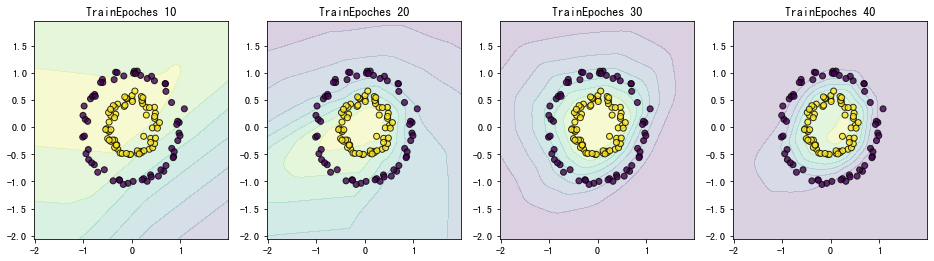

In [253]:
fig = plt.figure(figsize=(16, 4))
for i, epoch_num in enumerate([10, 20, 30, 40]):
    ax = plt.subplot(1, 4, i+1)
    model = train_epochs(epoch_num)
    acc = get_acc(model)
    print("TrainEpoches %d's Acc: %f" % (epoch_num, acc))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.set_title("TrainEpoches {}".format(epoch_num))
    ax.contourf(xx, yy, Z, alpha=0.2)
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, edgecolors='k', alpha=0.8)

## 激活函数

In [1]:
pwd

'/Users/HaoShaochun/Yam/All4NLP/Activation'

In [189]:
def gelu(x):
    return 0.5 * x * (1 + np.tanh(x * 0.7978845608 * (1 + 0.044715 * x * x)))

In [99]:
x = np.array([-2.0, -1.0, 0.0, 2.0, 3.0, 5.0], dtype=np.float16)

In [106]:
tf.nn.relu(x).numpy()

array([0., 0., 0., 2., 3., 5.], dtype=float16)

In [107]:
tf.nn.leaky_relu(x).numpy()

array([-0.4, -0.2,  0. ,  2. ,  3. ,  5. ], dtype=float16)

In [108]:
gelu(x)

array([-0.0454, -0.1589,  0.    ,  1.955 ,  2.996 ,  5.    ],
      dtype=float16)

In [109]:
tf.nn.tanh(x).numpy()

array([-0.964 , -0.7617,  0.    ,  0.964 ,  0.995 ,  1.    ],
      dtype=float16)

In [110]:
tf.nn.sigmoid(x).numpy()

array([0.1192, 0.2688, 0.5   , 0.8804, 0.9526, 0.993 ], dtype=float16)

In [111]:
tf.nn.softmax(x).numpy()

array([7.625e-04, 2.073e-03, 5.634e-03, 4.163e-02, 1.132e-01, 8.364e-01],
      dtype=float16)

In [117]:
x = np.linspace(-2, 2, 101, dtype=np.float16)

In [118]:
reluy = tf.nn.relu(x).numpy()
leaky_reluy = tf.nn.leaky_relu(x).numpy()
geluy = gelu(x)
tanhy = tf.nn.tanh(x).numpy()
sigmoidy = tf.nn.sigmoid(x).numpy()
softmaxy = tf.nn.softmax(x).numpy()

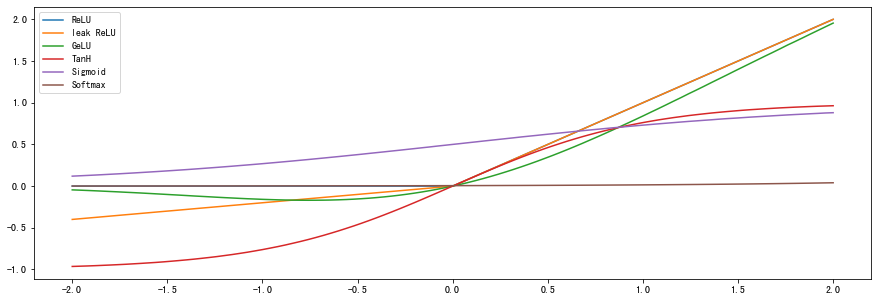

In [142]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 5))
ax.plot(x, reluy, label='ReLU')
ax.plot(x, leaky_reluy, label="leak ReLU")
ax.plot(x, geluy, label="GeLU")
ax.plot(x, tanhy, label="TanH")
ax.plot(x, sigmoidy, label="Sigmoid")
ax.plot(x, softmaxy, label="Softmax")
ax.legend(loc="upper left");